<a href="https://colab.research.google.com/github/rexian/ML/blob/main/knowledge_graph/kg_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API Knowledge Graph Construction

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
from rdflib import Graph
import networkx as nx
from matplotlib import pyplot as plt

# Load the kg.py file
import sys
sys.path.append('/content/')
from kg import rdf_to_nx

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>
</div>

## Input Data

In [4]:
services_df = pd.read_csv("data/services.csv",
                          sep=',',
                          dtype={'version': 'string'}).fillna('')

In [ ]:
services_df.head(1)

In [5]:
entity_types_df = pd.read_csv("data/entity_types.csv",
                              sep=',').fillna('')
entity_types_df.head(1)

,name,service
0,PurchaseReqnItemType,API_PURCHASEREQUISITION_2


In [6]:
properties_df = pd.read_csv("data/properties.csv",
                            sep=',').fillna('')
properties_df.head(1)

,service,entityType,name,label,type,maxLength,key,selectProperty
0,API_PURCHASEORDER_2,PURCHASEORDER_TYPE,CashDiscount1Percent,CD Percentage 1,Decimal,,,


In [7]:
navigations_df = pd.read_csv("data/navigations.csv",
                             sep=',').fillna('')
navigations_df.head(2)

,service,name,navigateFrom,navigateTo,multiplicity
0,API_PURCHASEORDER_2,_PurchaseOrder,PURCHASEORDERITEM_TYPE,PURCHASEORDER_TYPE,1
1,API_PURCHASEORDER_2,_PurchaseOrderItem,PURCHASEORDER_TYPE,PURCHASEORDERITEM_TYPE,*


In [8]:
entity_sets_df = pd.read_csv("data/entity_sets.csv",
                             sep=',').fillna('')
entity_sets_df.head(1)

,name,service,entityType
0,PurchaseOrder,API_PURCHASEORDER_2,PURCHASEORDER_TYPE


In [9]:
# Show the distribution of concepts in the data
data = {
    "Services": len(services_df),
    "Entity Sets": len(entity_sets_df),
    "Entity Types": len(entity_types_df),
    "Navigations": len(navigations_df),
    "Properties": len(properties_df)
}
pd.DataFrame.from_dict(data, orient='index', columns=['Count'])

,Count
Services,39
Entity Sets,101
Entity Types,101
Navigations,126
Properties,2366


## Knowledge Graph Construction

In [10]:
# The Knowledge Graph
kg = Graph()

In [13]:
construct_services = """
PREFIX odata: <http://example.org/odata#>
CONSTRUCT {
    ?service a odata:Service .
    ?service odata:description ?description .
    ?service odata:version ?version .
    ?service odata:name ?name .
}
WHERE
{
    BIND(IRI(CONCAT("http://data.example.org/Service/", UCASE(?name)))
    AS ?service)
}
"""

In [11]:
from rdflib import Dataset, Graph, Literal
from rdflib.plugins.sparql.processor import prepareQuery
import re

def transform(df: pd.DataFrame, construct_query: str,
              first: bool = False) -> Graph:
    """Transform Pandas DataFrame to RDFLib Graph given a
    SPARQL Construct Query."""

    # Setup query graph and result graph
    query_graph = Graph()
    result_graph = Graph()

    # Parse query and get headers
    query = prepareQuery(construct_query)
    invalid_pattern = re.compile(r"[^\w_]+")
    headers = dict((k, invalid_pattern.sub("_", k)) for k in df.columns)
    for _, row in df.iterrows():
        # Variable -> Value
        binding = dict((headers[k], Literal(row[k]))
                       for k in df.columns if len(str(row[k])) > 0)

        # Replace variables in query with values and execute query
        results = query_graph.query(query,
                                    initBindings=binding)
        for result in results:
            # Add triples to graph
            result_graph.add(result)
        if first:
            break
    return result_graph

In [14]:
print(transform(services_df, construct_services, True)
    .serialize(format='turtle'))

@prefix ns1: <http://example.org/odata#> .

<http://data.example.org/Service/API_PURCHASEORDER_2> a ns1:Service ;
    ns1:description "OData service for Purchase Order" ;
    ns1:name "API_PURCHASEORDER_2" ;
    ns1:version "4.0" .




In [15]:
kg += transform(services_df, construct_services)
print(f"Current Knowledge Graph size: {len(kg)} triples.")

Current Knowledge Graph size: 156 triples.


In [16]:
construct_entity_sets = """
PREFIX odata: <http://example.org/odata#>
CONSTRUCT {
    ?entitySet a odata:EntitySet .
    ?entitySet odata:entityType ?entityTypeIri .
    ?entitySet odata:name ?name .
}
WHERE
{
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                "/EntitySet/", UCASE(?name))) AS ?entitySet)
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                "/EntityType/", UCASE(?entityType))) AS ?entityTypeIri)
}
"""

# Add the triples to the KG and print the total number of triples
kg += transform(entity_sets_df, construct_entity_sets)
print(f"Current Knowledge Graph size: {len(kg)} triples.")

Current Knowledge Graph size: 457 triples.


In [17]:
construct_entity_types = """
PREFIX odata: <http://example.org/odata#>
CONSTRUCT {
    ?entityType a odata:EntityType .
    ?entityType odata:name ?name .
    ?entityType odata:service ?serviceIRI .
}
WHERE
{
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", UCASE(?name))) AS ?entityType)
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service))
                                                    AS ?serviceIRI)
}
"""

# Add the triples to the KG and print the total number of triples
kg += transform(entity_types_df, construct_entity_types)
print(f"Current Knowledge Graph size: {len(kg)} triples.")

Current Knowledge Graph size: 760 triples.


In [18]:
construct_properties = """
PREFIX odata: <http://example.org/odata#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
CONSTRUCT
{
    ?property a odata:Property .
    ?property odata:type ?type .
    ?property odata:name ?name .
    ?property odata:label ?label .
    ?property odata:maxLength ?maxLength .
    ?property odata:odataKey ?key_bool .
    ?property odata:selectProperty ?selectProperty_bool .

    # Link EntityType to Property
    ?entityTypeIRI odata:property ?property .
}
{
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", ?entityType,
                    "/Property/", UCASE(?name))) AS ?property)
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", ?entityType )) AS ?entityTypeIRI)
    BIND(xsd:boolean(?key) AS ?key_bool)
    BIND(xsd:boolean(?selectProperty) AS ?selectProperty_bool)
}
"""

# Add the triples to the KG and print the total number of triples
kg += transform(properties_df, construct_properties)
print(f"Current Knowledge Graph size: {len(kg)} triples.")

Current Knowledge Graph size: 14316 triples.


In [19]:
construct_navigations = """
PREFIX odata: <http://example.org/odata#>
CONSTRUCT
{
    ?navigation a odata:Navigation .
    ?navigation odata:name ?name .
    ?navigation odata:navigateFrom ?navigateFromIri .
    ?navigation odata:navigateTo ?navigateToIri .
    ?navigation odata:multiplicity ?multiplicity .
}
WHERE
{
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", UCASE(?navigateFrom),
                    "/Navigation/", UCASE(?name))) AS ?navigation)
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", UCASE(?navigateFrom)))
                    AS ?navigateFromIri)
    BIND(IRI(CONCAT("http://data.example.org/Service/", ?service,
                    "/EntityType/", UCASE(?navigateTo)))
                    AS ?navigateToIri)
}
"""

# Add the triples to the KG and print the total number of triples
kg += transform(navigations_df, construct_navigations)
print(f"Current Knowledge Graph size: {len(kg)} triples.")

Current Knowledge Graph size: 14942 triples.


In [20]:
find_entity_set_query = """
PREFIX odata: <http://example.org/odata#>
SELECT ?uri ?name
{{
    ?uri a odata:EntitySet .
    ?uri odata:name ?name .
    FILTER(?name = "{name}")
}}
LIMIT 1
"""
# Get Purchase order entity set
for res in kg.query(find_entity_set_query.format(name="PurchaseOrder")):
    PO_node = str(res.uri)
    print(f"URI of the Purchase order entity set:\n{PO_node}")

# Get Purchase requistion entity set
for res in kg.query(find_entity_set_query.format(name="PurchaseReqn")):
    PR_node = str(res.uri)
    print(f"URI of the Purchase requisition entity set:\n{PR_node}")

URI of the Purchase order entity set:
http://data.example.org/Service/API_PURCHASEORDER_2/EntitySet/PURCHASEORDER
URI of the Purchase requisition entity set:
http://data.example.org/Service/API_PURCHASEREQUISITION_2/EntitySet/PURCHASEREQN


In [22]:
# RDF graph to NetworkX graph conversion
G = rdf_to_nx(kg)

# Construct the subgraphs
G_po = G.subgraph(nx.shortest_path(G, PO_node))
G_pr = G.subgraph(nx.shortest_path(G, PR_node))
G_prpo = nx.union(G_pr, G_po)


In [24]:
from netgraph import Graph as NetGraph

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output visualizations generated may differ from those shown in the video.</p>

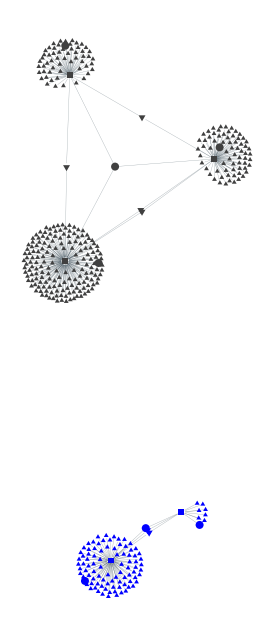

In [25]:
node_color= {
            node: ('#404040' if node in G_po
            else '#0000FF') for node in G_prpo}

node_shapes = {}
for node in G_prpo:
    if "Property" in node:
        node_shapes[node] = "^"
    elif "Navigation" in node:
        node_shapes[node] = "v"
    elif "EntityType" in node:
       node_shapes[node] = "s"
    else:
        node_shapes[node] = "o"

node_size = {}
for node in G_prpo:
    if "Property" in node:
        node_size[node] = .9
    else:
        node_size[node] = 1.3
fig, ax = plt.subplots(figsize=(20,8))

g = NetGraph(G_prpo,
          node_layout=nx.spring_layout(G_prpo, seed=1),
          node_edge_width = 0,
          node_size = node_size,
          edge_width=.1,
          node_color = node_color,
          node_shape = node_shapes,
          arrows=False,
          ax=ax
)
plt.show()

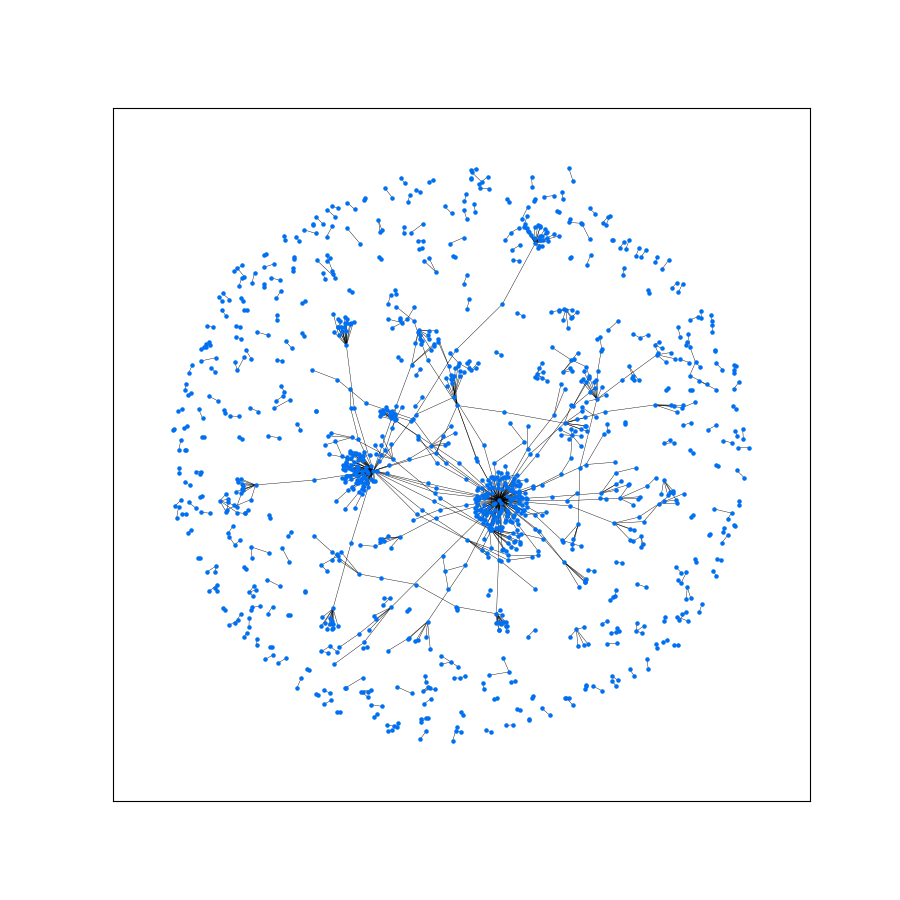

In [27]:
from IPython.display import Image
Image(filename='data/SampleKG.png')

In [28]:
kg.serialize(destination='api_knowledge_graph.ttl', format='turtle')

<Graph identifier=Nec27dabdb14044a19a102cc378e308ee (<class 'rdflib.graph.Graph'>)>

### Turle file
As briefly discussed in the previous lesson, a Turtle file is a way of writing down an RDF graph in a compact, human-friendly text format.
RDF (Resource Description Framework) represents data as triples:
- Subject → the thing being described
- Predicate → the property or relationship
- Object → the value or another thing it links to

**For example:**
- <code>:Alice :knows :Bob</code>

The same triple can be written in different serializations. N-Triples is very simple but verbose (each triple is written in full, one line per triple). Turtle (Terse RDF Triple Language) is more compact: it lets you shorten URIs with prefixes, group statements about the same subject, and use syntactic sugar like semicolons and commas to avoid repetition.

Here’s a small example in Turtle:


<code>@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix ex:   <http://example.org/> .
ex:Alice foaf:knows ex:Bob, ex:Charlie ;
         foaf:name "Alice" .
         
</code>
This expands to multiple RDF triples:
- Alice knows Bob
- Alice knows Charlie
- Alice has the name "Alice"

